## Completed exercise: Local Field Potentials and Current Source Density

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

from bmtk.builder.networks import NetworkBuilder

In [2]:
# L2/3 - 150 - 300
# L4 - 300 - 400
# L5 - 400 - 550
def get_coords(N, y_range, radius_min=0.0, radius_max=400.0):
    phi = 2.0 * np.pi * np.random.random([N])
    r = np.sqrt((radius_min**2 - radius_max**2) * np.random.random([N]) + radius_max**2)
    x = r * np.cos(phi)
    y = np.random.uniform(y_range[0], y_range[1], size=N)
    z = r * np.sin(phi)
    return x, y, z

In [3]:
cortcol_allsyns = NetworkBuilder("cortcol")
cortcol_basalsyns = NetworkBuilder("cortcol")
cortcol_apicalsyns = NetworkBuilder("cortcol")

In [4]:
for cortcol in [cortcol_allsyns, cortcol_basalsyns, cortcol_apicalsyns]:
    x, y, z = get_coords(20, y_range=[-400.0, -500.0])
    cortcol.add_nodes(
        N=20,  # 48
        # Reserved SONATA keywords used during simulation
        model_type="biophysical",
        model_template="ctdb:Biophys1.hoc",
        model_processing="aibs_perisomatic",
        dynamics_params="Scnn1a_485510712_params.json",
        morphology="Scnn1a_485510712_morphology.swc",
        # The x, y, z locations and orientations (in Euler angles) of each cell
        # Here, rotation around the pia-to-white-matter axis is randomized
        x=x,
        y=y,
        z=z,
        rotation_angle_xaxis=[0] * 20,
        rotation_angle_yaxis=np.random.uniform(0.0, 2 * np.pi, size=20),
        rotation_angle_zaxis=[3.646878266] * 20,
        tuning_angle=np.linspace(start=0.0, stop=360.0, num=20, endpoint=False),
        layer="L4",
        model_name="Scnn1a",
        ei="e",
    )

    x, y, z = get_coords(20, y_range=[-400.0, -500.0])
    cortcol.add_nodes(
        # Rorb excitatory cells
        N=20,
        model_type="biophysical",
        model_template="ctdb:Biophys1.hoc",
        dynamics_params="Rorb_486509958_params.json",
        morphology="Rorb_486509958_morphology.swc",
        model_processing="aibs_perisomatic",
        x=x,
        y=y,
        z=z,
        rotation_angle_xaxis=0,
        rotation_angle_yaxis=np.random.uniform(0.0, 2 * np.pi, size=20),
        rotation_angle_zaxis=np.full(20, 4.40),
        model_name="Rorb",
        ei="e",
        tuning_angle=np.linspace(start=0.0, stop=360.0, num=20, endpoint=False),
        layer="L4",
    )

    x, y, z = get_coords(20, y_range=[-400.0, -500.0])
    cortcol.add_nodes(
        # Nr5a1 excitatory cells
        N=20,
        model_type="biophysical",
        model_template="ctdb:Biophys1.hoc",
        dynamics_params="Nr5a1_485507735_params.json",
        morphology="Nr5a1_485507735_morphology.swc",
        model_processing="aibs_perisomatic",
        x=x,
        y=y,
        z=z,
        rotation_angle_xaxis=0,
        rotation_angle_yaxis=np.random.uniform(0.0, 2 * np.pi, size=20),
        rotation_angle_zaxis=np.full(20, 4.04),
        model_name="Nr5a1",
        tuning_angle=np.linspace(start=0.0, stop=360.0, num=20, endpoint=False),
        ei="e",
        layer="L4",
    )

    x, y, z = get_coords(15, y_range=[-400.0, -500.0])
    cortcol.add_nodes(
        N=15,  # 36
        model_type="biophysical",
        model_template="ctdb:Biophys1.hoc",
        model_processing="aibs_perisomatic",
        dynamics_params="Pvalb_473862421_params.json",
        morphology="Pvalb_473862421_morphology.swc",
        x=x,
        y=y,
        z=z,
        rotation_angle_xaxis=np.random.uniform(0.0, 2 * np.pi, size=15),
        rotation_angle_yaxis=np.random.uniform(0.0, 2 * np.pi, size=15),
        rotation_angle_zaxis=[2.539551891] * 15,
        model_name="Pvalb",
        ei="i",
        layer="L4",
    )


# Add synapses to the network
def tuning_angle(source, target, max_syns):
    # ignore autoapses
    if source["node_id"] == target["node_id"]:
        return 0

    # num of synapses is higher the closer the tuning_angles
    src_tuning = source["tuning_angle"]
    trg_tuning = target["tuning_angle"]
    dist = np.abs((src_tuning - trg_tuning + 180) % 360 - 180)
    p_dist = 1.0 - (np.max((dist, 10.0)) / 180.0)
    return np.random.binomial(n=max_syns, p=p_dist)


cortcol_allsyns.add_edges(
    source={"ei": "e"},
    target={"ei": "e"},
    connection_rule=tuning_angle,
    connection_params={"max_syns": 5},  # pass in options to tuning_angle function
    syn_weight=3.0e-05,
    delay=2.0,
    dynamics_params="ExcToExc.json",
    model_template="exp2syn",
    target_sections=["basal", "apical"],
    distance_range=[30.0, 150.0],
    # Will allow us to use our own custom functions to set syn_weight during simulation
    weight_function="set_syn_weight",
)

cortcol_allsyns.add_edges(
    ## Exc --> Inh type connections.
    source={"ei": "e"},
    target={"ei": "i"},
    # Each source (ei='e') cell will connect once to every target (e) cell
    connection_rule=1,
    # SONATA keywords
    syn_weight=0.0006,
    delay=2.0,
    dynamics_params="ExcToInh.json",
    model_template="exp2syn",
    # Special BMTK attributes specifying where to set target synape location
    target_sections=["somatic", "basal"],
    distance_range=[0.0, 1.0e20],
)

cortcol_allsyns.add_edges(
    ## Inh --> Exc type connections.
    source={"ei": "i"},
    target={"ei": "e"},
    connection_rule=1,
    syn_weight=0.0002,
    delay=2.0,
    dynamics_params="InhToExc.json",
    model_template="exp2syn",
    target_sections=["somatic", "basal", "apical"],
    distance_range=[0.0, 50.0],
)


def ignore_autapses(source, target):
    # No synapses if source == target, otherwise randomize
    if source["node_id"] == target["node_id"]:
        return 0
    else:
        return np.random.randint(1, 5)


cortcol_allsyns.add_edges(
    ## Inh --> Inh type connections.
    source={"ei": "i"},
    target={"ei": "i"},
    connection_rule=ignore_autapses,
    syn_weight=0.00015,
    delay=2.0,
    dynamics_params="InhToInh.json",
    model_template="exp2syn",
    target_sections=["somatic", "basal"],
    distance_range=[0.0, 1.0e20],
)

cortcol_allsyns.build()
cortcol_allsyns.save(output_dir="network_allsynapses")

# ---- Basal synapses ----
cortcol_basalsyns.add_edges(
    source={"ei": "e"},
    target={"ei": "e"},
    connection_rule=tuning_angle,
    connection_params={"max_syns": 5},  # pass in options to tuning_angle function
    syn_weight=3.0e-05,
    delay=2.0,
    dynamics_params="ExcToExc.json",
    model_template="exp2syn",
    target_sections=["basal"],
    distance_range=[30.0, 150.0],
    # Will allow us to use our own custom functions to set syn_weight during simulation
    weight_function="set_syn_weight",
)

cortcol_basalsyns.add_edges(
    ## Exc --> Inh type connections.
    source={"ei": "e"},
    target={"ei": "i"},
    # Each source (ei='e') cell will connect once to every target (e) cell
    connection_rule=1,
    # SONATA keywords
    syn_weight=0.0006,
    delay=2.0,
    dynamics_params="ExcToInh.json",
    model_template="exp2syn",
    # Special BMTK attributes specifying where to set target synape location
    target_sections=["somatic", "basal"],
    distance_range=[0.0, 1.0e20],
)

cortcol_basalsyns.add_edges(
    ## Inh --> Exc type connections.
    source={"ei": "i"},
    target={"ei": "e"},
    connection_rule=1,
    syn_weight=0.0002,
    delay=2.0,
    dynamics_params="InhToExc.json",
    model_template="exp2syn",
    target_sections=["somatic", "basal"],
    distance_range=[0.0, 50.0],
)

cortcol_allsyns.add_edges(
    ## Inh --> Inh type connections.
    source={"ei": "i"},
    target={"ei": "i"},
    connection_rule=ignore_autapses,
    syn_weight=0.00015,
    delay=2.0,
    dynamics_params="InhToInh.json",
    model_template="exp2syn",
    target_sections=["somatic", "basal"],
    distance_range=[0.0, 1.0e20],
)

cortcol_basalsyns.build()
cortcol_basalsyns.save(output_dir="network_basalsynapses")

# ---- Apical synapses ----
cortcol_apicalsyns.add_edges(
    source={"ei": "e"},
    target={"ei": "e"},
    connection_rule=tuning_angle,
    connection_params={"max_syns": 5},  # pass in options to tuning_angle function
    syn_weight=3.0e-05,
    delay=2.0,
    dynamics_params="ExcToExc.json",
    model_template="exp2syn",
    target_sections=["basal"],
    distance_range=[30.0, 150.0],
    # Will allow us to use our own custom functions to set syn_weight during simulation
    weight_function="set_syn_weight",
)
cortcol_apicalsyns.add_edges(
    ## Exc --> Inh type connections.
    source={"ei": "e"},
    target={"ei": "i"},
    # Each source (ei='e') cell will connect once to every target (e) cell
    connection_rule=1,
    # SONATA keywords
    syn_weight=0.0006,
    delay=2.0,
    dynamics_params="ExcToInh.json",
    model_template="exp2syn",
    # Special BMTK attributes specifying where to set target synape location
    target_sections=["somatic", "basal"],
    distance_range=[0.0, 1.0e20],
)
cortcol_apicalsyns.add_edges(
    ## Inh --> Exc type connections.
    source={"ei": "i"},
    target={"ei": "e"},
    connection_rule=1,
    syn_weight=0.0002,
    delay=2.0,
    dynamics_params="InhToExc.json",
    model_template="exp2syn",
    target_sections=["apical"],
    distance_range=[0.0, 50.0],
)

cortcol_apicalsyns.add_edges(
    ## Inh --> Inh type connections.
    source={"ei": "i"},
    target={"ei": "i"},
    connection_rule=ignore_autapses,
    syn_weight=0.00015,
    delay=2.0,
    dynamics_params="InhToInh.json",
    model_template="exp2syn",
    target_sections=["somatic", "basal"],
    distance_range=[0.0, 1.0e20],
)

cortcol_apicalsyns.build()
cortcol_apicalsyns.save(output_dir="network_apicalsynapses")

Create external nodes - virtual cells that provide inputs to the network.

In [5]:
np.random.seed(42)
external = NetworkBuilder("external")
external.add_nodes(
    N=50,
    model_type="virtual",
    model_template="lgnmodel:sOFF_TF8",
    x=np.random.uniform(0.0, 240.0, 50),
    y=np.random.uniform(0.0, 120.0, 50),
    spatial_size=1.0,
    pop_name="tOFF",
    dynamics_params="sOFF_TF8.json",
)
external.add_nodes(
    N=50,
    model_type="virtual",
    model_template="lgnmodel:sON_TF8",
    x=np.random.uniform(0.0, 240.0, 50),
    y=np.random.uniform(0.0, 120.0, 50),
    spatial_size=1.0,
    pop_name="tON",
    dynamics_params="sON_TF8.json",
)

external_basalsyns = NetworkBuilder("external")
external_basalsyns.add_nodes(
    N=50,
    model_type="virtual",
    model_template="lgnmodel:sOFF_TF8",
    x=np.random.uniform(0.0, 240.0, 50),
    y=np.random.uniform(0.0, 120.0, 50),
    spatial_size=1.0,
    pop_name="tOFF",
    dynamics_params="sOFF_TF8.json",
)
external_basalsyns.add_nodes(
    N=50,
    model_type="virtual",
    model_template="lgnmodel:sON_TF8",
    x=np.random.uniform(0.0, 240.0, 50),
    y=np.random.uniform(0.0, 120.0, 50),
    spatial_size=1.0,
    pop_name="tON",
    dynamics_params="sON_TF8.json",
)

external_apicalsyns = NetworkBuilder("external")
external_apicalsyns.add_nodes(
    N=50,
    model_type="virtual",
    model_template="lgnmodel:sOFF_TF8",
    x=np.random.uniform(0.0, 240.0, 50),
    y=np.random.uniform(0.0, 120.0, 50),
    spatial_size=1.0,
    pop_name="tOFF",
    dynamics_params="sOFF_TF8.json",
)
external_apicalsyns.add_nodes(
    N=50,
    model_type="virtual",
    model_template="lgnmodel:sON_TF8",
    x=np.random.uniform(0.0, 240.0, 50),
    y=np.random.uniform(0.0, 120.0, 50),
    spatial_size=1.0,
    pop_name="tON",
    dynamics_params="sON_TF8.json",
)

In [6]:
external.add_edges(
    source=external.nodes(),  # Select all LGN cells as the sources
    target=cortcol_allsyns.nodes(ei="e"),  # select V1 exc cells are the target
    connection_rule=lambda *_: np.random.randint(0, 5),
    syn_weight=0.0003,
    delay=2.0,
    dynamics_params="LGN_ExcToExc.json",
    model_template="exp2syn",
    target_sections=["basal", "apical", "somatic"],
    distance_range=[0.0, 1e20],
)

external.add_edges(
    source=external.nodes(),  # Select all LGN cells as the sources
    target=cortcol_allsyns.nodes(ei="i"),  # select V1 exc cells are the target
    connection_rule=lambda *_: np.random.randint(0, 5),
    syn_weight=0.002,
    delay=2.0,
    dynamics_params="LGN_ExcToInh.json",
    model_template="exp2syn",
    target_sections=["basal", "apical"],
    distance_range=[0.0, 1e20],
)

external.save(output_dir="network_allsynapses")

In [7]:
external_basalsyns.add_edges(
    source=external_basalsyns.nodes(),  # Select all LGN cells as the sources
    target=cortcol_basalsyns.nodes(ei="e"),  # select V1 exc cells are the target
    connection_rule=lambda *_: np.random.randint(0, 5),
    syn_weight=0.0003,
    delay=2.0,
    dynamics_params="LGN_ExcToExc.json",
    model_template="exp2syn",
    target_sections=["basal", "somatic"],
    distance_range=[0.0, 50.0],
)

external_basalsyns.add_edges(
    source=external_basalsyns.nodes(),  # Select all LGN cells as the sources
    target=cortcol_basalsyns.nodes(ei="i"),  # select V1 exc cells are the target
    connection_rule=lambda *_: np.random.randint(0, 5),
    syn_weight=0.002,
    delay=2.0,
    dynamics_params="LGN_ExcToInh.json",
    model_template="exp2syn",
    target_sections=["basal"],
    distance_range=[0.0, 1e20],
)

external_basalsyns.save(output_dir="network_basalsynapses")

In [8]:
external_apicalsyns.add_edges(
    source=external_apicalsyns.nodes(),  # Select all LGN cells as the sources
    target=cortcol_apicalsyns.nodes(ei="e"),  # select V1 exc cells are the target
    connection_rule=lambda *_: np.random.randint(0, 5),
    syn_weight=0.0003,
    delay=2.0,
    dynamics_params="LGN_ExcToExc.json",
    model_template="exp2syn",
    target_sections=["apical", "somatic"],
    distance_range=[50.0, 1e20],
)

external_apicalsyns.add_edges(
    source=external_apicalsyns.nodes(),  # Select all LGN cells as the sources
    target=cortcol_apicalsyns.nodes(ei="i"),  # select V1 exc cells are the target
    connection_rule=lambda *_: np.random.randint(0, 5),
    syn_weight=0.002,
    delay=2.0,
    dynamics_params="LGN_ExcToInh.json",
    model_template="exp2syn",
    target_sections=["apical"],
    distance_range=[0.0, 1e20],
)

external_apicalsyns.save(output_dir="network_apicalsynapses")

In [9]:
# Load the existing config file
with open("config.lfp.json", "r") as f:
    config = json.load(f)

# Create config for basal synapses
basal_config = config.copy()
basal_config["manifest"]["$NETWORK_DIR"] = "$BASE_DIR/network_basalsynapses"
basal_config["manifest"]["$OUTPUT_DIR"] = "$BASE_DIR/output_basalsynapses"

with open("config.lfp_basal.json", "w") as f:
    json.dump(basal_config, f, indent=2)


# Create config for apical synapses
apical_config = config.copy()
apical_config["manifest"]["$NETWORK_DIR"] = "$BASE_DIR/network_apicalsynapses"
apical_config["manifest"]["$OUTPUT_DIR"] = "$BASE_DIR/output_apicalsynapses"

with open("config.lfp_apical.json", "w") as f:
    json.dump(apical_config, f, indent=2)

print("Generated configuration files for basal and apical synapses simulations.")

Generated configuration files for basal and apical synapses simulations.


### 3. Run the simulation:
- Use `BioNet` to run the simulation with the generated config.json file. The simulation should be run for 3 seconds with a time step of 0.1 ms. The results should be saved in the outputs folder.
- Remember to compile the [./components/mechanisms](components/mechanisms) before running the simulation. You can do this by running the following command in the terminal:
```bash
! cd components/mechanisms && nrnivmodl modfiles
```

In [10]:
from bmtk.simulator import bionet

bionet.reset()
conf = bionet.Config.from_json("config.lfp.json")
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

numprocs=1
2025-07-22 14:29:09,550 [INFO] Created log file
2025-07-22 14:29:09,777 [INFO] Building cells.
2025-07-22 14:29:11,380 [INFO] Building recurrent connections
2025-07-22 14:29:11,870 [INFO] Building virtual cell stimulations for virt_exc_spikes
2025-07-22 14:29:13,355 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2025-07-22 14:29:13,356 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2025-07-22 14:29:13,356 [INFO] Block save every 5000 steps
2025-07-22 14:29:37,078 [INFO]     step:5000 t_sim:500.00 ms
2025-07-22 14:29:59,246 [INFO]     step:10000 t_sim:1000.00 ms
2025-07-22 14:30:22,011 [INFO]     step:15000 t_sim:1500.00 ms
2025-07-22 14:30:44,465 [INFO]     step:20000 t_sim:2000.00 ms
2025-07-22 14:31:07,177 [INFO]     step:25000 t_sim:2500.00 ms
2025-07-22 14:31:28,558 [INFO]     step:30000 t_sim:3000.00 ms
2025-07-22 14:31:28,599 [INFO] Simulation completed in 2.0 minutes, 15.24 seconds 


In [11]:
bionet.reset()
conf = bionet.Config.from_json("config.lfp_basal.json")
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2025-07-22 14:31:28,605 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2025-07-22 14:31:28,641 [INFO] Building cells.
2025-07-22 14:31:30,849 [INFO] Building recurrent connections
2025-07-22 14:31:31,397 [INFO] Building virtual cell stimulations for virt_exc_spikes
2025-07-22 14:31:32,874 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2025-07-22 14:31:32,874 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2025-07-22 14:31:32,874 [INFO] Block save every 5000 steps
2025-07-22 14:32:36,349 [INFO]     step:5000 t_sim:500.00 ms
2025-07-22 14:33:41,365 [INFO]     step:10000 t_sim:1000.00 ms
2025-07-22 14:34:42,728 [INFO]     step:15000 t_sim:1500.00 ms
2025-07-22 14:35:46,557 [INFO]     step:20000 t_sim:2000.00 ms
2025-07-22 14:36:51,202 [INFO]     step:25000 t_sim:2500.00 ms
2025-07-22 14:37:53,640 [INFO]     step:30000 t_sim:3000.00 ms
2025-07-22 14:37:53,681 [INFO] Simulation completed in 6.0 minutes, 20.81 seconds 


In [12]:
bionet.reset()
conf = bionet.Config.from_json("config.lfp_apical.json")
conf.build_env()

net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2025-07-22 14:37:53,689 [INFO] Created log file
Mechanisms already loaded from path: ./components/mechanisms.  Aborting.
2025-07-22 14:37:53,727 [INFO] Building cells.
2025-07-22 14:37:56,834 [INFO] Building recurrent connections
2025-07-22 14:37:57,462 [INFO] Building virtual cell stimulations for virt_exc_spikes
2025-07-22 14:37:57,778 [WARNING] Could not find target synaptic location for edge-type 101, Please check target_section and/or distance_range properties
2025-07-22 14:37:58,906 [INFO] Running simulation for 3000.000 ms with the time step 0.100 ms
2025-07-22 14:37:58,907 [INFO] Starting timestep: 0 at t_sim: 0.000 ms
2025-07-22 14:37:58,907 [INFO] Block save every 5000 steps
2025-07-22 14:40:14,576 [INFO]     step:5000 t_sim:500.00 ms
2025-07-22 14:42:18,739 [INFO]     step:10000 t_sim:1000.00 ms
2025-07-22 14:44:26,554 [INFO]     step:15000 t_sim:1500.00 ms
2025-07-22 14:46:34,000 [INFO]     step:20000 t_sim:2000.00 ms
2025-07-22 14:48:41,406 [INFO]     step:25000 t_sim:2500

### 4. Plot the results:
- Plot the raster plot of the network activity. The x-axis should represent time and the y-axis should represent the neuron index. Use different colors for different populations.
- Create a 2D plot of the LFPs recorded by the linear probe. The x-axis should represent time and the y-axis should represent the electrode number.

Plot raster of network activity:

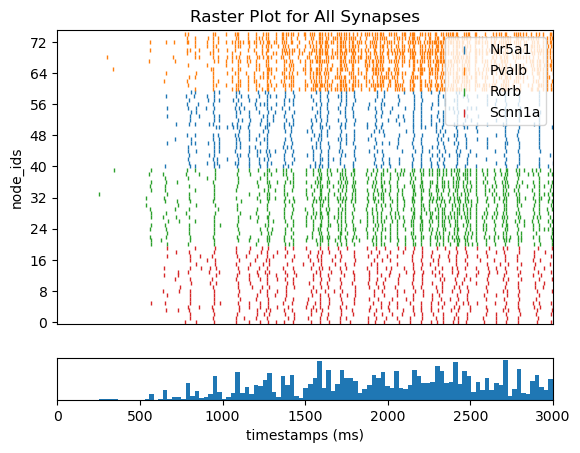

In [13]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(
    config_file="config.lfp.json",
    spikes_file="output_allsynapses/spikes.csv",
    title="Raster Plot for All Synapses",
    group_by="model_name",
)

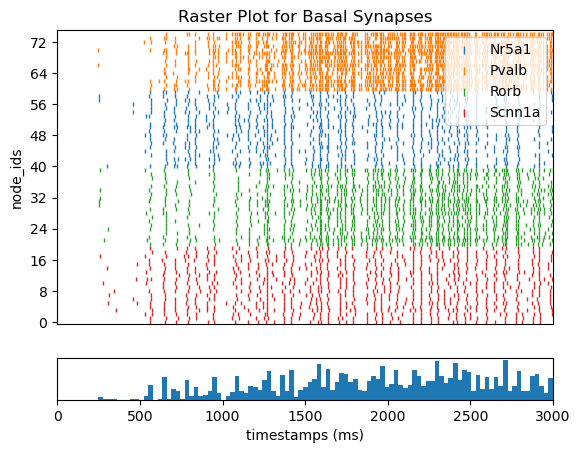

In [14]:
_ = plot_raster(
    config_file="config.lfp_basal.json",
    spikes_file="output_basalsynapses/spikes.csv",
    title="Raster Plot for Basal Synapses",
    group_by="model_name",
)

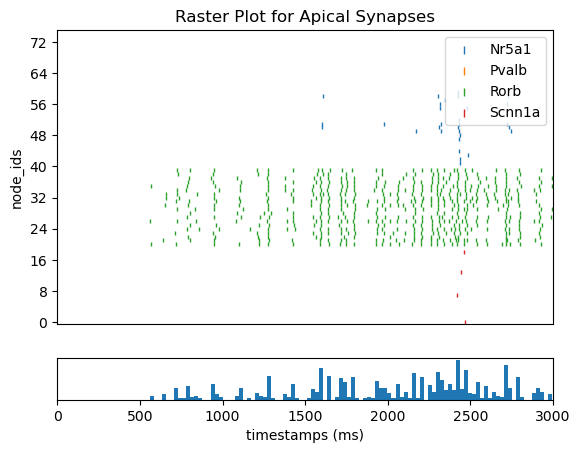

In [15]:
_ = plot_raster(
    config_file="config.lfp_apical.json",
    spikes_file="output_apicalsynapses/spikes.csv",
    title="Raster Plot for Apical Synapses",
    group_by="model_name",
)

Plot the LFPs:

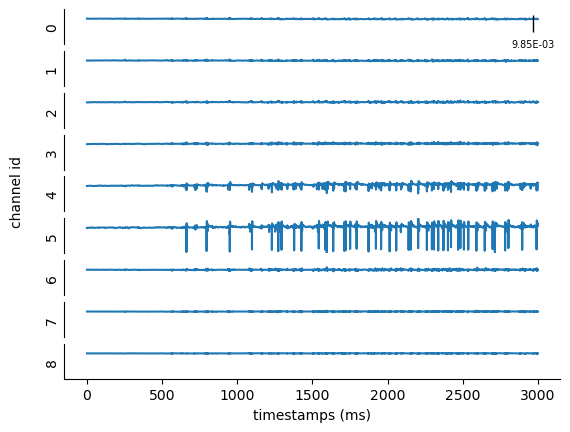

In [16]:
from bmtk.analyzer.ecp import plot_ecp

_ = plot_ecp(config_file="config.lfp.json", report_name="cortical_electrode")

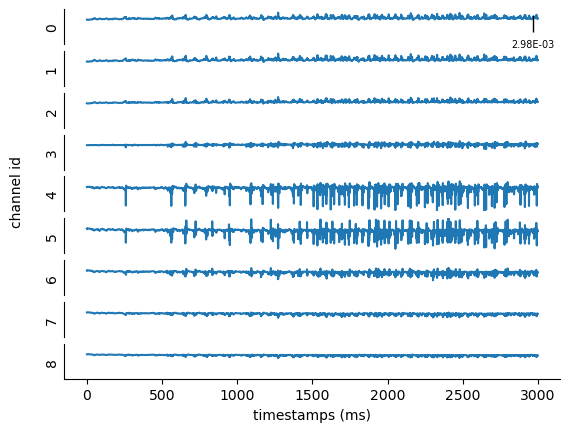

In [17]:
_ = plot_ecp(config_file="config.lfp_basal.json", report_name="cortical_electrode")

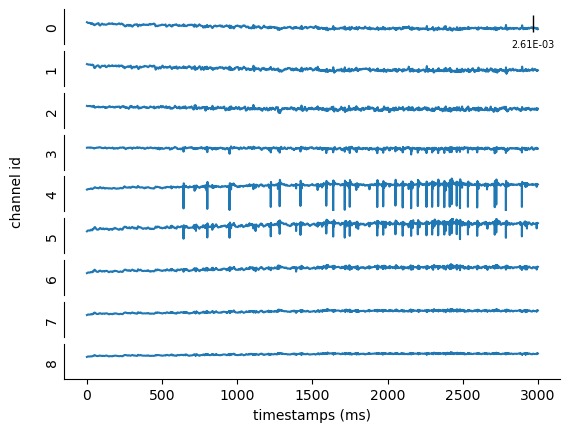

In [18]:
_ = plot_ecp(config_file="config.lfp_apical.json", report_name="cortical_electrode")

### 5. Calculate the CSD:
- Calculate the CSD from the simulated LFPs using the delta-iCSD method. You can find the implementation of the delta-iCSD method in the [icsd_scripts](icsd_scripts) folder.

In [19]:
import sys
import quantities as pq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("icsd_scripts/")

import icsd

from get_csd_input_dict import get_csd_input_dict

delta_icsd_allsynapses = get_csd_input_dict(
    "output_allsynapses/cortical_electrode.h5",
)
delta_icsd_basal = get_csd_input_dict(
    "output_basalsynapses/cortical_electrode.h5",
)
delta_icsd_apical = get_csd_input_dict(
    "output_apicalsynapses/cortical_electrode.h5",
)

In [20]:
csd_dict = dict(
    delta_icsd=icsd.DeltaiCSD(**delta_icsd_allsynapses),
    delta_icsd_basal=icsd.DeltaiCSD(**delta_icsd_basal),
    delta_icsd_apical=icsd.DeltaiCSD(**delta_icsd_apical),
)

csd_raw = {"delta_icsd": [], "delta_icsd_basal": [], "delta_icsd_apical": []}
csd_smooth = {"delta_icsd": [], "delta_icsd_basal": [], "delta_icsd_apical": []}
# Iterate through the csd_dict and compute raw and smoothed CSD

for method, csd_obj in list(csd_dict.items()):
    csd_raw[method] = csd_obj.get_csd()  # num_channels x trial_duration
    csd_smooth[method] = csd_obj.filter_csd(
        csd_raw[method]
    )  # num_channels x trial_duration

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ], 
a = [ 2.213 ]


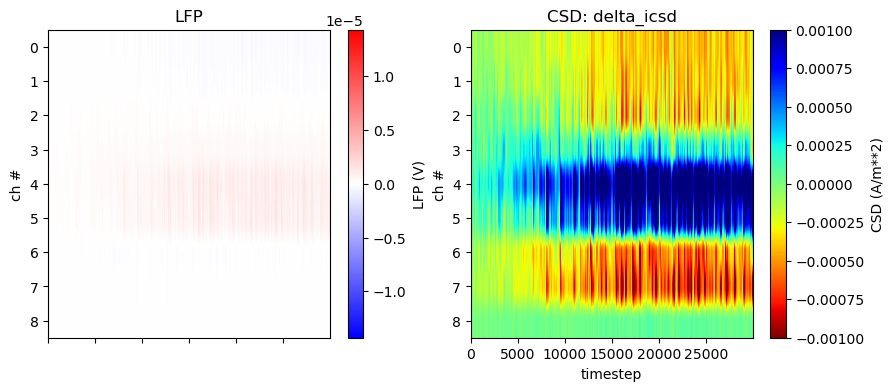

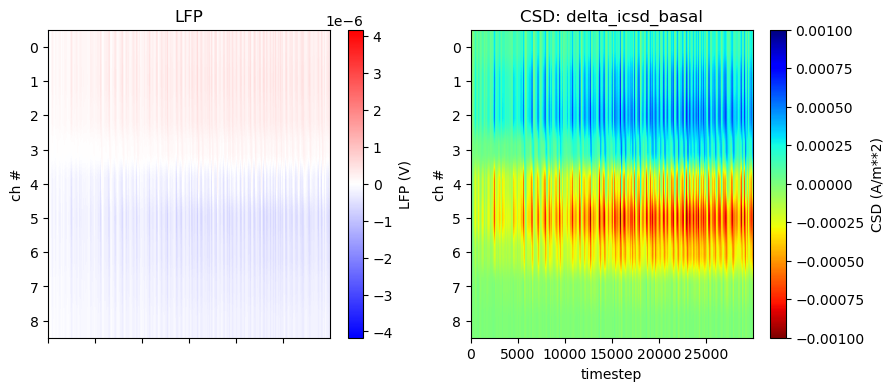

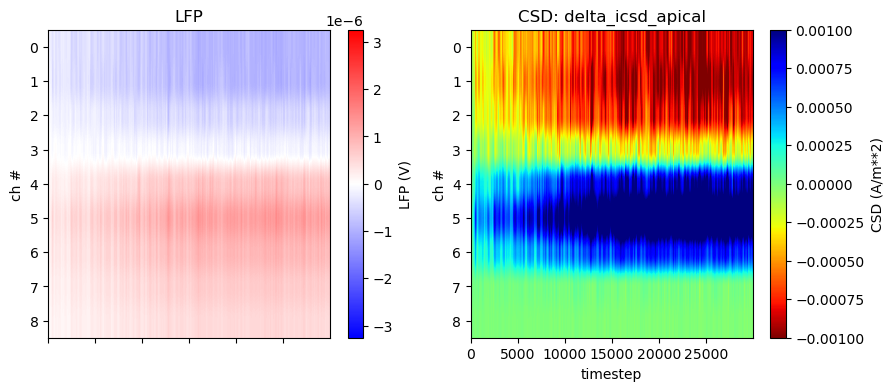

In [22]:
import matplotlib.pyplot as plt

delta_icsd_dict = dict(
    delta_icsd=delta_icsd_allsynapses,
    delta_icsd_basal=delta_icsd_basal,
    delta_icsd_apical=delta_icsd_apical,
)

for method, csdi in list(csd_smooth.items()):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    lfp_data = delta_icsd_dict[method]["lfp"]

    # plot LFP signal
    ax = axes[0]
    im = ax.imshow(
        np.array(lfp_data),
        origin="upper",
        vmin=-abs(lfp_data).max(),
        vmax=abs(lfp_data).max(),
        cmap="bwr",
    )
    ax.axis(ax.axis("tight"))
    cb = plt.colorbar(im, ax=ax)
    cb.set_label("LFP (%s)" % lfp_data.dimensionality.string)
    ax.set_xticklabels([])
    ax.set_title("LFP")
    ax.set_ylabel("ch #")

    # # plot raw csd estimate
    # ax = axes[1]
    # im = ax.imshow(
    #     np.array(csd_raw[method]),
    #     origin="upper",
    #     vmin=-abs(csd_raw[method]).max(),
    #     vmax=abs(csd_raw[method]).max(),
    #     cmap="jet_r",
    # )
    # ax.axis(ax.axis("tight"))
    # ax.set_title(csd_obj.name)
    # cb = plt.colorbar(im, ax=ax)
    # cb.set_label("CSD (%s)" % csd_raw[method].dimensionality.string)
    # ax.set_xticklabels([])
    # ax.set_ylabel("ch #")

    # plot spatially filtered csd estimate
    ax = axes[1]
    im = ax.imshow(
        np.array(csdi),
        origin="upper",
        vmin=-0.001,  # abs(csdi).max() / 4,
        vmax=0.001,  # abs(csdi).max() / 4,
        cmap="jet_r",
    )
    ax.axis(ax.axis("tight"))
    ax.set_title("CSD: %s" % method)
    cb = plt.colorbar(im, ax=ax)
    cb.set_label("CSD (%s)" % csdi.dimensionality.string)
    ax.set_ylabel("ch #")
    ax.set_xlabel("timestep")